# swissALTI3D

Extract a square subset of SwissTopo's [swissALTI3D](https://www.swisstopo.admin.ch/en/geodata/height/alti3d.html) dataset.
Using the Cloud Optimized Geotiff (COG) version, for speed and convenience.

In [1]:
import json
import os
import subprocess

import numpy as np

import requests

import pyproj as ppj
import rasterio

from PIL import Image

import matplotlib.pyplot as plt

from tqdm import tqdm

## Download chunks

In [2]:
# Conversion between WGS84 and LV95
WGS84 = ppj.CRS.from_epsg(4326)
LV95 = ppj.CRS.from_epsg(2056)
wgs84_to_lv95 = ppj.Transformer.from_crs(WGS84, LV95, always_xy=True)

In [3]:
# Choose location
cy, cx = 46.936841, 6.730526
cx, cy = wgs84_to_lv95.transform(cx, cy)
radius = 3000
cx, cy, radius

(2546081.1222069995, 1198660.876528902, 3000)

In [4]:
# Bounding box
margin = 50
x_min = cx - radius - margin
x_max = cx + radius + margin
y_min = cy - radius - margin
y_max = cy + radius + margin

In [5]:
# Required files
# Note: each file covers a single 1000x1000 chunk, anchored bottom right
ix_min = int(x_min // 1000)
ix_max = int(x_max // 1000) + 1
iy_min = int(y_min // 1000)
iy_max = int(y_max // 1000) + 1
ix_min, ix_max, iy_min, iy_max

(2543, 2550, 1195, 1202)

In [6]:
# How many chunks are needed
(ix_max - ix_min) * (iy_max - iy_min)

49

In [7]:
# Create folder for downloaded files, if needed
folder = "../data/swissalti3d_2019/"
if not os.path.exists(folder):
    os.mkdir(folder)

In [8]:
# Enumerate chunks
pairs = {}
for ix in range(ix_min, ix_max):
    for iy in range(iy_min, iy_max):
        name = f"swissalti3d_2019_{ix}-{iy}_0.5_2056_5728.tif"
        path = folder + name
        url = f"https://data.geo.admin.ch/ch.swisstopo.swissalti3d/swissalti3d_2019_{ix}-{iy}/{name}"
        if not os.path.exists(path):
            pairs[(ix, iy)] = (path, url)

In [9]:
# Download chunks
for path, url in tqdm(pairs.values()):
    data = requests.get(url).content
    with open(path, "wb") as file:
        file.write(data)

0it [00:00, ?it/s]


## Stitch TIFF images

In [10]:
# Load raster data
buffer = np.zeros((iy_max - iy_min, ix_max - ix_min, 2000, 2000), dtype=np.float32)
with tqdm(total=(iy_max - iy_min) * (ix_max - ix_min)) as progress:
    for ix in range(ix_min, ix_max):
        for iy in range(iy_min, iy_max):
            name = f"swissalti3d_2019_{ix}-{iy}_0.5_2056_5728.tif"
            path = folder + name
            with rasterio.open(path) as dataset:
                buffer[iy - iy_min, ix - ix_min] = dataset.read(1)
            progress.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:09<00:00,  5.01it/s]


In [11]:
# Flatten
heightmap = buffer[::-1].transpose(0, 2, 1, 3).reshape(buffer.shape[0] * buffer.shape[2], buffer.shape[1] * buffer.shape[3])

In [12]:
# Bounds coordinates, in LV95
left = ix_min * 1000
right = ix_max * 1000
bottom = iy_min * 1000
top = iy_max * 1000

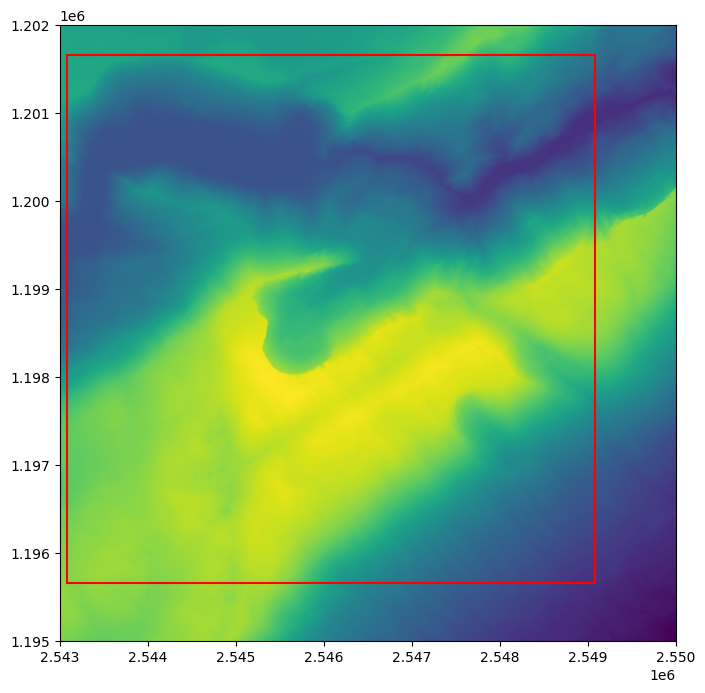

In [13]:
# Show heightmap
# Note: using reduced resolution, for speed
_, ax = plt.subplots(figsize=(8, 8))
ax.imshow(heightmap[::10, ::10], extent=(left, right, bottom, top))
ax.plot(
    [cx - radius, cx - radius, cx + radius, cx + radius, cx - radius],
    [cy - radius, cy + radius, cy + radius, cy - radius, cy - radius],
    c="r",
)
ax.set_aspect("equal")
plt.show()

In [14]:
# Crop to area-of-interes
margin_left = (cx - radius - left) / 0.5
margin_bottom = (cy - radius - bottom) / 0.5
margin_top = (top - cy - radius) / 0.5
margin_right = (right - cx - radius) / 0.5
crop_height = int((top - bottom) / 0.5 - margin_top - margin_bottom)
crop_width = int((right - left) / 0.5 - margin_right - margin_left)
assert crop_width == crop_height
crop_x = int(margin_left)
crop_y = int(margin_bottom)
heightmap = heightmap[crop_y:crop_y + crop_height, crop_x:crop_x + crop_width]
heightmap.shape

(12000, 12000)

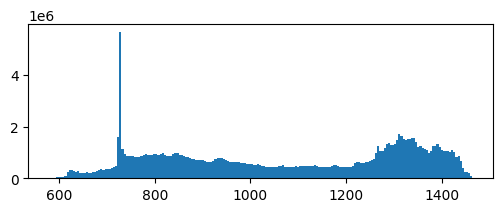

In [15]:
# Overall distribution of altitude data
_, ax = plt.subplots(figsize=(6, 2))
ax.hist(heightmap.reshape(-1), bins=200)
plt.show()

## Export layers as BMP

In [16]:
# Create new folder for temporary files
folder = "../data/tmp/"
assert not os.path.exists(folder)
os.mkdir(folder)

In [27]:
# Thickness of each layer
z_step = 20.0
z_transition = 1.0

# Actual altitude range
z_min = heightmap.min()
z_max = heightmap.max()

# From this point, slice regularly
# Note: make sure we start just above the lowest point
zs = np.arange(z_min + z_step, z_max, z_step)

z_min, z_max, len(zs)

(579.7361, 1464.2621, 44)

In [28]:
# Print size, in mm
print_radius = 50

# Expected resolution (i.e. size of a single pixel), in mm
print_resolution = 0.1

In [19]:
# Make sure we did not mess up the circle thing
assert heightmap.shape[0] == heightmap.shape[1]

In [20]:
# How many heightmap pixels in a single 0.1mm?
heightmap.shape[0] * print_resolution / print_radius

24.0

In [21]:
# Heightmap can be downsampled without noticeable quality loss
image_size = int(2 * print_radius / print_resolution)
image_size

1000

In [22]:
# How thick (in mm) is a layer, in the print?
z_step / radius * print_radius

0.33333333333333337

In [23]:
# Export grayscale image for each layer
for iz in tqdm(range(len(zs))):
    z = zs[iz]
    
    # Renormalize heightmap, so that z is at 0.5, and data is in [0.0, 1.0]
    h = np.tanh((heightmap - z) / z_transition)
    h = (0.5 - h * 0.5).clip(0.0, 1.0)
    
    # Convert to PIL image
    image = (h * 255).clip(0, 255).astype(np.uint8)
    image = Image.fromarray(image)
    
    # Downscale
    # TODO could probably downscale once beforehand, right?
    image.thumbnail((image_size, image_size), Image.Resampling.LANCZOS)
    
    # Export as BMP, which is one of the supported format of Potrace
    image.save(folder + f"{iz:04d}.bmp")

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [05:49<00:00,  7.94s/it]


## Vectorize layers using Potrace

In [24]:
# Make sure you have installed Potrace!
# https://potrace.sourceforge.net/
POTRACE_PATH = "../potrace-1.16.win64/potrace.exe"

In [32]:
# Export as SVG (e.g. for Fusion 360)
for iz in tqdm(range(len(zs))):
    # TODO fine-tune
    args = [
        POTRACE_PATH,
        "-b",
        "svg",
        "-o",
        folder + f"{iz:04d}.svg",
        folder + f"{iz:04d}.bmp",
    ]
    result = subprocess.run(args)
    assert result.returncode == 0

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.29it/s]
